In [1]:
LOAD = False

# reload module each time cell is run
%load_ext autoreload
%autoreload 2

import numpy as np
from numba import njit, prange, boolean, int32, double
from numba.experimental import jitclass
import time

import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# tools
from tools import linear_interp # for linear interpolation
from tools import misc # various tools
from tools.ConsumptionSavingModel import ConsumptionSavingModel # baseline model classes

# solution and plot routines
import solve_GP2002 as gp
import tools.plot as plot

from tools import SimulatedMinimumDistance as SMD

In [2]:
add_str = ''
est_par = ("beta","rho")
est_par_tex = (r'$\hat{\beta}$',r'$\hat{\rho}$')

# choose gamma (fixed)
fixed_par = ('sigma_perm','sigma_trans','p','r','mu_a_init','sigma_a_init')
fixed_par_tex = (r'$\sigma_{n}$',r'$\sigma_{u}$',r'$p$',r'$r$',r'$\tilde{\omega}_{26}$',r'$\sigma_{\omega_{26}}$')

In [3]:
# moment function
@njit
def mom_fun(data):
    return np.log(data.C_avg)

# load data
consumption,income,weight = gp.load_data()
mom_data = np.log(consumption)
theta0 = [0.944, 1.860] 

In [4]:
# Estimate the baseline model
model_base = gp.GP2002()
model_base.draw_random()

smd_base = SMD.SimulatedMinimumDistance(model_base,mom_data,mom_fun,print_iter=False,options={'disp':True})
if LOAD:
    smd_base.est = theta0
else:
    smd_base.estimate(theta0,est_par,weight)

theta_base = smd_base.est

# update model parameters
for p in range(len(est_par)):
    setattr(model_base.par,est_par[p],theta_base[p]) 

# solve and simulate model
model_base.solve() 
model_base.draw_random()
model_base.simulate()

Optimization terminated successfully.
         Current function value: 0.540269
         Iterations: 31
         Function evaluations: 62


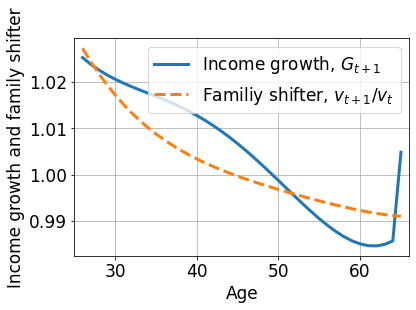

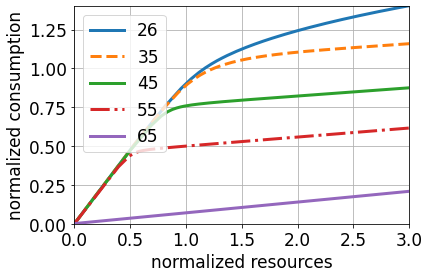

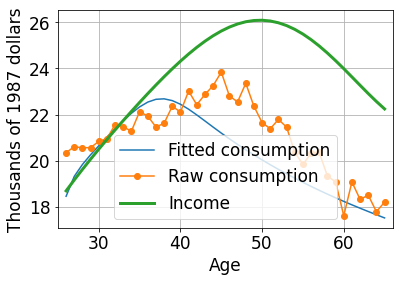

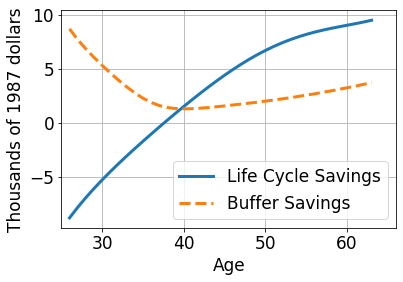

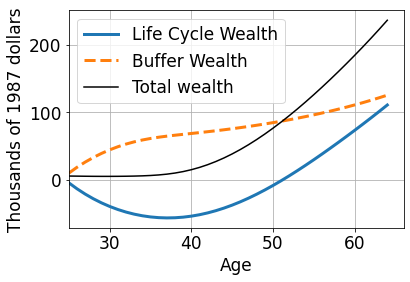

In [5]:
# Construct baseline plots 
plot.cali(model_base)
plot.fig1(model_base,add_str)
plot.fig5(model_base,consumption,income,add_str)
plot.fig7(theta_base,est_par,add_str)

Time to calculate sensitivity measure: 0.74 minutes (robust: False)
Time to calculate sensitivity measure: 3.80 minutes (robust: True)


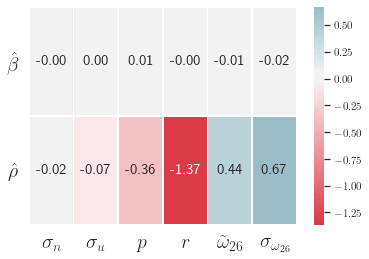

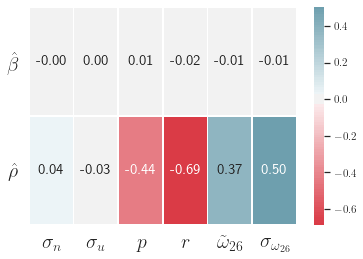

In [6]:
# Construct sensitivity of parameters to calibrated parameters
for do_robust in [False,True]:
    t0 = time.time()
    smd_base.sensitivity(theta_base,est_par,weight,fixed_par,do_robust=do_robust)
    if not do_robust: time_sens = time.time() - t0
    print(f'Time to calculate sensitivity measure: {(time.time() - t0)/60:2.2f} minutes (robust: {do_robust})')

plot.sens_fig_tab(smd_base.sens,smd_base.sens_ela,theta_base,est_par_tex,fixed_par_tex,add_str=add_str)
plot.sens_fig_tab(smd_base.sens_robust,smd_base.sens_ela_robust,theta_base,est_par_tex,fixed_par_tex,add_str=add_str+'_robust')

In [7]:
#######################################################################
# sensitivity of savings-decomposition
print('Sensitivity of savings motives.')
H_base = gp.saving_decomposition_wrap(theta_base,est_par)
num_h = len(H_base)

# gradient wrt theta
print('Caclulating the gradient of savings motives wrt. theta')
grad_theta = gp.num_grad(gp.saving_decomposition_wrap,theta_base,num_h,1.0e-5,est_par)

# gradient wrt gamma
print('Caclulating the gradient of savings motives wrt. gamma')
gamma = np.array([ getattr(model_base.par,name) for name in  fixed_par])
grad_gamma = gp.num_grad(gp.saving_decomposition_wrap,gamma,num_h,1.0e-5,fixed_par,theta_base,est_par)

# sensitivity measure
sens_H = grad_gamma + grad_theta @ smd_base.sens
sens_H_robust = grad_gamma + grad_theta @ smd_base.sens_robust

# elasticity
num_gamma = len(gamma)
ela_H = np.empty((num_h,num_gamma))
ela_H_robust = np.empty((num_h,num_gamma))
for g in range(len(gamma)):
    for h in range(num_h):
        ela_H[h,g] = sens_H[h,g]*gamma[g]/H_base[h]
        ela_H_robust[h,g] = sens_H_robust[h,g]*gamma[g]/H_base[h]

age = 30
ela_H30 = ela_H[age-27,:]
ela_H30_robust = ela_H_robust[age-27,:]
age = 60
ela_H60 = ela_H[age-27,:]
ela_H60_robust = ela_H_robust[age-27,:]

Sensitivity of savings motives.
Caclulating the gradient of savings motives wrt. theta
Caclulating the gradient of savings motives wrt. gamma


In [8]:
# calulate savings decomposition for various risk-free interest rates
pct_grid = [0, 1, 2, 3, 4, 5]

noest_H30 = np.empty(len(pct_grid)) 
noest_H60 = np.empty(len(pct_grid))
for i,pct in enumerate(pct_grid):
    model = gp.GP2002()
    model.par.r = model.par.r*(1.0 + pct/100)
    #model.draw_random()

    # update model parameters to baseline estimates and current r
    for p in range(len(est_par)):
        setattr(model.par,est_par[p],theta_base[p]) 

    # calculate savings motives for new values
    upd_par = ("beta","rho","r")
    upd_val = np.empty(len(upd_par))
    for p in range(len(upd_par)):
        upd_val[p] = getattr(model.par,upd_par[p])
       
    (S,S_lc,S_b,W,W_lc,W_b,H) = gp.saving_decomposition(upd_val,upd_par)
    noest_H30[i] = H[30-27]
    noest_H60[i] = H[60-27]
    

# Brute-force estimation of elasticities
Takes some time

In [9]:
brute_est = np.empty((len(est_par),len(fixed_par)))
brute_H = np.empty((2,len(fixed_par)))

time_brute = 0.0
for p in range(len(fixed_par)):
    model = gp.GP2002()
    model.draw_random()
    
    # update relevant parameter to 1pct increase
    old_val = getattr(model.par,fixed_par[p])
    new_val = getattr(model.par,fixed_par[p]) * (1.01)
    setattr(model.par,fixed_par[p],new_val) 
    print(f'Re-estimating with {fixed_par[p]} = {new_val:2.5f}')
    
    # Estimate theta with new calibration
    t0 = time.time()
    smd = SMD.SimulatedMinimumDistance(model,mom_data,mom_fun,print_iter=False,options={'disp':True})
    smd.estimate(theta0,est_par,weight)
    theta_now = smd.est
    
    time_brute += time.time() - t0

    # Update model parameters to estimated values and store them
    for t in range(len(est_par)):
        setattr(model.par,est_par[t],theta_now[t]) 
        brute_est[t,p] = 100.0*(theta_now[t] - theta_base[t])/theta_base[t]

    # Calculate savings motives for re-estimated values       
    H_now = gp.saving_decomposition_wrap(theta_now,est_par,[new_val,],(fixed_par[p],))
    brute_H[0,p] = 100.0*(H_now[30-27]-H_base[30-27])/H_base[30-27]
    brute_H[1,p] = 100.0*(H_now[60-27]-H_base[60-27])/H_base[60-27]
    


Re-estimating with sigma_perm = 0.02141
Optimization terminated successfully.
         Current function value: 0.540034
         Iterations: 30
         Function evaluations: 61
Re-estimating with sigma_trans = 0.04444
Optimization terminated successfully.
         Current function value: 0.540008
         Iterations: 34
         Function evaluations: 67
Re-estimating with p = 0.00305
Optimization terminated successfully.
         Current function value: 0.540203
         Iterations: 31
         Function evaluations: 61
Re-estimating with r = 0.03474
Optimization terminated successfully.
         Current function value: 0.530279
         Iterations: 29
         Function evaluations: 59
Re-estimating with mu_a_init = 0.06179
Optimization terminated successfully.
         Current function value: 0.539369
         Iterations: 30
         Function evaluations: 61
Re-estimating with sigma_a_init = 1.80184
Optimization terminated successfully.
         Current function value: 0.537955
      

In [10]:
print(f'Time to calculate sensitivity measure: {time_sens/60:2.2f} minutes')
print(f'Time to calculate brute force measure: {time_brute/60:2.2f} minutes')
print(f'{time_brute/time_sens:2.2f} times faster')

Time to calculate sensitivity measure: 0.74 minutes
Time to calculate brute force measure: 17.61 minutes
23.73 times faster


In [11]:
# Tables
num_theta = len(est_par)
num_gamma = len(fixed_par)
name = 'output\gp2002_sens' + add_str 
with open(name + '.tex',"w") as file:
    file.write("\\begin{tabular}{l*{%d}{c}} \\toprule \n" %(3*num_theta))
    file.write("& \\multicolumn{%d}{c}{Sensitivity measure} " %(2*num_theta))
    file.write("& \\multicolumn{%d}{c}{Re-estimation} \\\\ \\cmidrule(lr){2-5}   \n" %(num_theta))
    file.write("& \\multicolumn{%d}{c}{Approximation} & \\multicolumn{%d}{c}{Robust} & \\multicolumn{%d}{c}{(brute force)} \\\\ \\cmidrule(lr){2-3} \\cmidrule(lr){4-5} \\cmidrule(lr){6-7}  \n" %(num_theta,num_theta,num_theta))
    for i in range(3):
        for p in range(num_theta):
            file.write("& %s " %est_par_tex[p])
    file.write("\\\\ \\cmidrule(lr){2-%d} \n " %(3*num_theta+1))

    
    for g in range(num_gamma):
        file.write(" %s " %fixed_par_tex[g])
        # sensitivity: Approximate
        for t in range(num_theta):
            file.write("& %2.3f " %smd_base.sens_ela[t,g])   
        # sensitivity: Robust
        for t in range(num_theta):
            file.write("& %2.3f " %smd_base.sens_ela_robust[t,g])
        # brute-force
        for t in range(num_theta):
            file.write("& %2.3f " %brute_est[t,g])
        file.write("\\\\ \n ")

    file.write("\\bottomrule \n \\end{tabular}" )

    
name = 'output\gp2002_sens_H' + add_str 
with open(name + '.tex',"w") as file:
    file.write("\\begin{tabular}{l*{%d}{c}} \\toprule \n" %(3*num_theta))
    file.write("& \\multicolumn{%d}{c}{Sensitivity measure} " %(2*num_theta))
    file.write("& \\multicolumn{%d}{c}{Re-estimation} \\\\ \\cmidrule(lr){2-5}   \n" %(num_theta))
    file.write("& \\multicolumn{%d}{c}{Approximation} & \\multicolumn{%d}{c}{Robust} & \\multicolumn{%d}{c}{(brute force)} \\\\ \\cmidrule(lr){2-3} \\cmidrule(lr){4-5} \\cmidrule(lr){6-7}  \n" %(num_theta,num_theta,num_theta))
    for i in range(3):
            file.write("& $H^e_{30}$ & $H^e_{60}$ ")
    file.write("\\\\ \\cmidrule(lr){2-%d} \n " %(3*num_theta+1))

    
    for g in range(num_gamma):
        file.write(" %s " %fixed_par_tex[g])
        # sensitivity: Approximate
        file.write(f"& {ela_H30[g]:2.3f} & {ela_H60[g]:2.3f} ")
        # sensitivity: Robust
        file.write(f"& {ela_H30_robust[g]:2.3f} & {ela_H60_robust[g]:2.3f} ")
        # brute-force
        for t in range(2):
            file.write("& %2.3f " %brute_H[t,g])
        file.write("\\\\ \n ")

    file.write("\\bottomrule \n \\end{tabular}" )

## Brute-force re-estimation of the model for various risk-free interest rates
This takes some time!

In [12]:
est_rho = np.empty(len(pct_grid))
est_beta = np.empty(len(pct_grid)) 
est_H30 = np.empty(len(pct_grid)) 
est_H60 = np.empty(len(pct_grid))
for i,pct in enumerate(pct_grid):
    model = gp.GP2002()
    model.par.r = model.par.r*(1.0 + pct/100)
    model.draw_random()

    smd = SMD.SimulatedMinimumDistance(model,mom_data,mom_fun,print_iter=False,options={'disp':True})
    
    if pct<0.01:
        smd.est = theta_base
    else:
        smd.estimate(theta0,est_par,weight)
    theta = smd.est

    # update model parameters
    for p in range(len(est_par)):
        setattr(model.par,est_par[p],theta[p]) 
        
    est_rho[i] = model.par.rho
    est_beta[i] = model.par.beta

    # calculate savings motives for re-estimated values
    upd_par = ("beta","rho","r")
    upd_val = np.empty(len(upd_par))
    for p in range(len(upd_par)):
        upd_val[p] = getattr(model.par,upd_par[p])
       
    (S,S_lc,S_b,W,W_lc,W_b,H) = gp.saving_decomposition(upd_val,upd_par)
    est_H30[i] = H[30-27]
    est_H60[i] = H[60-27]


Optimization terminated successfully.
         Current function value: 0.530279
         Iterations: 29
         Function evaluations: 59
Optimization terminated successfully.
         Current function value: 0.520491
         Iterations: 32
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: 0.510901
         Iterations: 31
         Function evaluations: 60
Optimization terminated successfully.
         Current function value: 0.501510
         Iterations: 33
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: 0.492314
         Iterations: 32
         Function evaluations: 62


In [13]:
dest_rho = est_rho[1:] - est_rho[0]
dest_beta = est_beta[1:] - est_beta[0] 
dest_H30 = est_H30[1:] - est_H30[0] 
dest_H60 = est_H60[1:] - est_H60[0]
dnoest_H30 = noest_H30[1:] - noest_H30[0] 
dnoest_H60 = noest_H60[1:] - noest_H60[0] 

dest_rho_e = 100*dest_rho/est_rho[0]
dest_beta_e = 100*dest_beta/est_beta[0]
dest_H30_e = 100*dest_H30/est_H30[0]
dest_H60_e = 100*dest_H60/est_H60[0]
dnoest_H30_e = 100*dnoest_H30/noest_H30[0]
dnoest_H60_e = 100*dnoest_H60/noest_H60[0]

g = 3 # interest rate parameter in gamma

num_theta = len(theta)
num_gamma = len(fixed_par_tex)
num_pct = len(dest_rho)

name = 'output\gp2002_sens_r' +  add_str 
with open(name + '.tex',"w") as file:
    file.write("\\begin{tabular}{l*{%d}{c}} \\toprule \n" %num_pct)
    file.write("& \\multicolumn{%d}{c}{ Change in interest rate, $r$ } \\\\ " %(num_pct) )
    file.write("\\cmidrule(lr){2-%d}  \n" %(num_pct+1))
    for p in range(num_pct):
        file.write("& %s pct. " %pct_grid[p+1])

    # sensitivity
    file.write("\\\\ \\midrule \n")
    file.write("& \\multicolumn{%d}{c}{ \\emph{Sensitivity measure (Approximate)} } \\\\ "  %(num_pct))
    file.write("\\cmidrule(lr){2-%d}  " %(num_pct+1))
    for t in range(num_theta):
        file.write("\n %s " %est_par_tex[t])
        for p in range(num_pct):
            file.write("& %2.3f " %(np.array(pct_grid[p+1])*smd_base.sens_ela[t,g]))
        file.write("\\\\")
        
    file.write("\\cmidrule(lr){2-%d}  \n" %(num_pct+1))    
    file.write("& \\multicolumn{%d}{c}{ \\emph{Sensitivity measure (Robust)} } \\\\ "  %(num_pct))
    file.write("\\cmidrule(lr){2-%d}  " %(num_pct+1))
    for t in range(num_theta):
        file.write("\n %s " %est_par_tex[t])
        for p in range(num_pct):
            file.write("& %2.3f " %(np.array(pct_grid[p+1])*smd_base.sens_ela_robust[t,g]))
        file.write("\\\\")

    # brute force
    file.write("\\cmidrule(lr){2-%d}  \n" %(num_pct+1))
    file.write("& \\multicolumn{%d}{c}{ \\emph{Re-estimated $\\theta$ (brute force)} } \\\\ "  %(num_pct))
    file.write("\\cmidrule(lr){2-%d}  " %(num_pct+1))
    for t in range(num_theta):
        file.write("\n %s " %est_par_tex[t])
        for p in range(num_pct):
            if t==1:
                file.write(" & %2.3f " %dest_rho_e[p])
            else:
                file.write("& %2.3f " %dest_beta_e[p])            
        file.write("\\\\ ")
        
    file.write("\\bottomrule  \\end{tabular} \n")
    
    
# savings motive
name = 'output\gp2002_sens_r_H' +  add_str 
with open(name + '.tex',"w") as file:
    file.write("\\begin{tabular}{l*{%d}{c}} \\toprule \n" %num_pct)
    file.write("& \\multicolumn{%d}{c}{ Change in interest rate, $r$ } \\\\ " %(num_pct) )
    file.write("\\cmidrule(lr){2-%d}  \n" %(num_pct+1))
    for p in range(num_pct):
        file.write("& %s pct. " %pct_grid[p+1])

    # sensitivity
    file.write("\\\\ \\midrule \n")
    file.write("& \\multicolumn{%d}{c}{ \\emph{Sensitivity measure (Approximate)} } \\\\ "  %(num_pct))
    file.write("\\cmidrule(lr){2-%d}  " %(num_pct+1))
    
    file.write("\n $H^e_{30}$ ")
    for p in range(num_pct):
        file.write(" & %2.3f " %(np.array(pct_grid[p+1])*ela_H30[g]))
    file.write("\n \\\\ $H^e_{60}$ ")
    for p in range(num_pct):
        file.write(" & %2.3f " %(np.array(pct_grid[p+1])*ela_H60[g]))
    
    # robust
    file.write("\\\\ \\cmidrule(lr){2-%d}  \n" %(num_pct+1))
    file.write("& \\multicolumn{%d}{c}{ \\emph{Sensitivity measure (Robust)} } \\\\ "  %(num_pct))
    file.write("\\cmidrule(lr){2-%d}  " %(num_pct+1))
    
    file.write("\n $H^e_{30}$ ")
    for p in range(num_pct):
        file.write(" & %2.3f " %(np.array(pct_grid[p+1])*ela_H30_robust[g]))
    file.write("\n \\\\ $H^e_{60}$ ")
    for p in range(num_pct):
        file.write(" & %2.3f " %(np.array(pct_grid[p+1])*ela_H60_robust[g]))

    # brute force
    file.write("\\\\ \\cmidrule(lr){2-%d}  \n" %(num_pct+1))
    file.write("& \\multicolumn{%d}{c}{ \\emph{Re-estimated $\\theta$ (brute force)} } \\\\ "  %(num_pct))
    file.write("\\cmidrule(lr){2-%d}" %(num_pct+1))
    
    file.write("\n $H^e_{30}$ ")
    for p in range(num_pct):
        file.write(" & %2.3f " %dest_H30_e[p])
    file.write("\\\\ \n $H^e_{60}$ ")
    for p in range(num_pct):
        file.write(" & %2.3f " %dest_H60_e[p])      
           
            
    # Current practice
    file.write("\\\\ \\cmidrule(lr){2-%d}  \n" %(num_pct+1))
    file.write("& \\multicolumn{%d}{c}{ \\emph{Fixed $\\theta$ }} \\\\ "  %(num_pct))
    file.write("\\cmidrule(lr){2-%d}" %(num_pct+1))
    
    file.write("\n $B^e_{30}$ ")
    for p in range(num_pct):
        file.write(" & %2.3f " %dnoest_H30_e[p])
    file.write("\\\\ \n $B^e_{60}$ ")
    for p in range(num_pct):
        file.write(" & %2.3f " %dnoest_H60_e[p])  
        
    file.write("\\\\ \n ")
        
    file.write("\\bottomrule  \\end{tabular} \n")

## Compare approximate, robust and brute force derivatives

In [14]:
# brute-force gradient
gamma = np.array([ getattr(model_base.par,name) for name in  fixed_par])
def estimate_func(gamma,gamma_names,theta): 
    
    # set calibrated values
    for i in range(len(gamma_names)):
        setattr(model_base.par,gamma_names[i],gamma[i]) 
        print(f'{gamma_names[i]} = {gamma[i]:2.5f}')
        
    # estimate model
    smd_base.estimate(theta,est_par,weight)
    
    return smd_base.est

args = (theta_base,)
brute_grad = smd_base.num_grad_obj(estimate_func,gamma,fixed_par,1.0e-4,*args)
[setattr(model_base.par,fixed_par[i],gamma[i]) for i in range(len(fixed_par))];

sigma_perm = 0.02130
sigma_trans = 0.04400
p = 0.00302
r = 0.03440
mu_a_init = 0.06118
sigma_a_init = 1.78400
Optimization terminated successfully.
         Current function value: 0.540158
         Iterations: 32
         Function evaluations: 63
sigma_perm = 0.02110
sigma_trans = 0.04400
p = 0.00302
r = 0.03440
mu_a_init = 0.06118
sigma_a_init = 1.78400
Optimization terminated successfully.
         Current function value: 0.540379
         Iterations: 31
         Function evaluations: 61
sigma_perm = 0.02120
sigma_trans = 0.04410
p = 0.00302
r = 0.03440
mu_a_init = 0.06118
sigma_a_init = 1.78400
Optimization terminated successfully.
         Current function value: 0.540210
         Iterations: 31
         Function evaluations: 60
sigma_perm = 0.02120
sigma_trans = 0.04390
p = 0.00302
r = 0.03440
mu_a_init = 0.06118
sigma_a_init = 1.78400
Optimization terminated successfully.
         Current function value: 0.540328
         Iterations: 31
         Function evaluations: 60
sigma_pe

[None, None, None, None, None, None]

In [15]:
num_theta = len(est_par)
num_gamma = len(fixed_par)
name = 'output\gp2002_grad' + add_str 
with open(name + '.tex',"w") as file:
    file.write("\\begin{tabular}{l*{%d}{c}} \\toprule \n" %(3*num_theta))
    file.write("& \\multicolumn{%d}{c}{Sensitivity measure} " %(2*num_theta))
    file.write("& \\multicolumn{%d}{c}{Re-estimation} \\\\ \\cmidrule(lr){2-5}   \n" %(num_theta))
    file.write("& \\multicolumn{%d}{c}{Approximation} & \\multicolumn{%d}{c}{Robust} & \\multicolumn{%d}{c}{(brute force)} \\\\ \\cmidrule(lr){2-3} \\cmidrule(lr){4-5} \\cmidrule(lr){6-7}  \n" %(num_theta,num_theta,num_theta))
    for i in range(3):
        for p in range(num_theta):
            file.write("& %s " %est_par_tex[p])
    file.write("\\\\ \\cmidrule(lr){2-%d} \n " %(3*num_theta+1))
    
    for g in range(num_gamma):
        file.write(" %s " %fixed_par_tex[g])
        # sensitivity: Approximate
        for t in range(num_theta):
            file.write("& %2.3f " %smd_base.sens[t,g])   
        # sensitivity: Robust
        for t in range(num_theta):
            file.write("& %2.3f " %smd_base.sens_robust[t,g])
        # brute-force
        for t in range(num_theta):
            file.write("& %2.3f " %brute_grad[t,g])
        file.write("\\\\ \n ")

    file.write("\\bottomrule \n \\end{tabular}" )

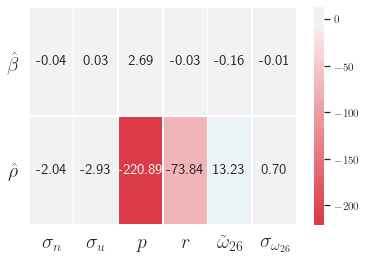

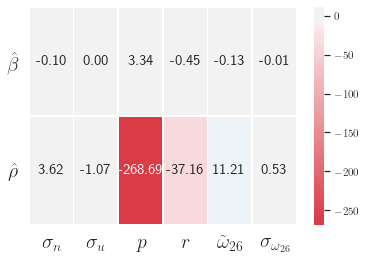

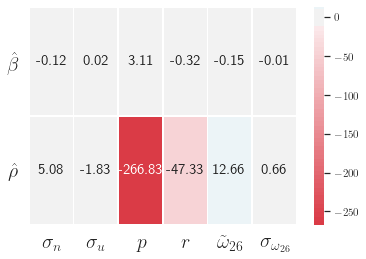

In [16]:
plot.sens_fig_tab(smd_base.sens,smd_base.sens,theta_base,est_par_tex,fixed_par_tex,add_str=add_str+'_grad_approx',save=True)
plot.sens_fig_tab(smd_base.sens_robust,smd_base.sens_robust,theta_base,est_par_tex,fixed_par_tex,add_str=add_str+'_grad_robust',save=True)
plot.sens_fig_tab(brute_grad,brute_grad,theta_base,est_par_tex,fixed_par_tex,add_str=add_str+'_grad_brute',save=True)